In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("../data/ETTh1.csv")
df['date'] = pd.to_datetime(df['date'])

df['P_high'] = np.sqrt(df['HUFL']**2 + df['HULL']**2)
df['P_mid']  = np.sqrt(df['MUFL']**2 + df['MULL']**2)
df['P_low']  = np.sqrt(df['LUFL']**2 + df['LULL']**2)

In [2]:
def create_windowed_features(df, window_sizes=[6, 12, 24]):
    # Use only P_high, P_mid, P_low and OT (no redundant HUFL, HULL, etc.)
    base_features = ['P_high', 'P_mid', 'P_low', 'OT']
    results = {}

    for window in window_sizes:
        new_cols = {}

        for feat in base_features:
            roll = df[feat].rolling(window, min_periods=1)
            new_cols[f'{feat}_mean_{window}h'] = roll.mean()
            new_cols[f'{feat}_std_{window}h'] = roll.std().fillna(0)

        df_window = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
        results[window] = df_window.copy()

    return results

windowed_dfs = create_windowed_features(df)

print("Created windowed features for window sizes: 6h, 12h, 24h")
print(f"Base features for windowing: P_high, P_mid, P_low, OT")
print(f"Original features: {len(df.columns)}")
print(f"Features with 6h window: {len(windowed_dfs[6].columns)}")
print(f"Features with 12h window: {len(windowed_dfs[12].columns)}")
print(f"Features with 24h window: {len(windowed_dfs[24].columns)}")

Created windowed features for window sizes: 6h, 12h, 24h
Base features for windowing: P_high, P_mid, P_low, OT
Original features: 11
Features with 6h window: 19
Features with 12h window: 19
Features with 24h window: 19


	Feature Correlations
          P_high     P_mid     P_low
P_high  1.000000  0.826777  0.425835
P_mid   0.826777  1.000000  0.231758
P_low   0.425835  0.231758  1.000000

Note: High correlations (>0.8) may indicate redundancy


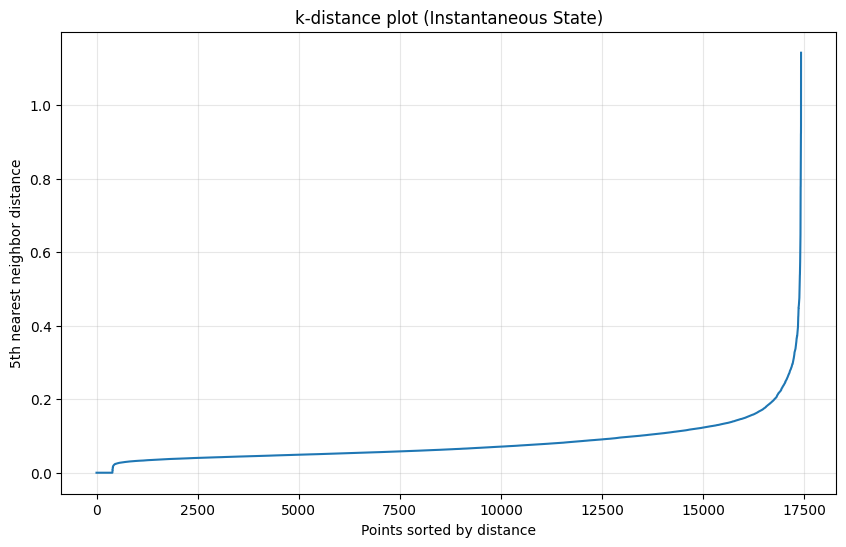

In [25]:
# DBSCAN finds rare LOAD combinations (NOT including OT)
instantaneous_features = ['P_high', 'P_mid', 'P_low']
X_dbscan = df[instantaneous_features].values
scaler_dbscan = StandardScaler()
X_dbscan_scaled = scaler_dbscan.fit_transform(X_dbscan)

# Check correlation to verify features aren't redundant
print("\tFeature Correlations")
corr_matrix = df[instantaneous_features].corr()
print(corr_matrix)
print("\nNote: High correlations (>0.8) may indicate redundancy")

# K-distance plot for epsilon selection
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X_dbscan_scaled)
distances, _ = nbrs.kneighbors(X_dbscan_scaled)
k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title("k-distance plot (Instantaneous State)")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th nearest neighbor distance")
plt.grid(True, alpha=0.3)
plt.show()

The elbow in the k-distance plot provides a heuristic for selecting ε.

Optimal eps from elbow method: 0.1710


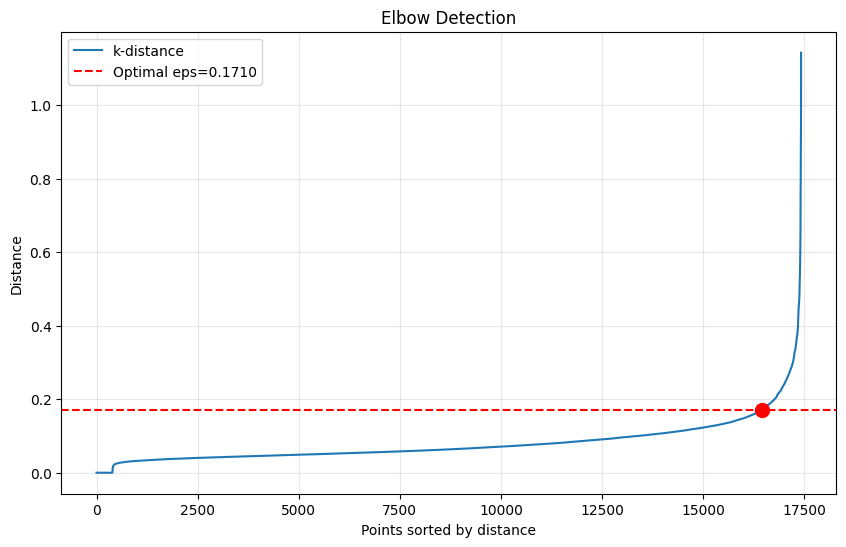

In [4]:
x = np.arange(len(k_distances))
y = k_distances

p1, p2 = np.array([x[0], y[0]]), np.array([x[-1], y[-1]])
dist = np.abs(np.cross(p2-p1, p1-np.vstack((x, y)).T)) / np.linalg.norm(p2-p1)

elbow_index = np.argmax(dist) 
eps_optimal = k_distances[elbow_index]
print(f"Optimal eps from elbow method: {eps_optimal:.4f}")

# Visualize the elbow point
plt.figure(figsize=(10, 6))
plt.plot(k_distances, label='k-distance')
plt.axhline(eps_optimal, color='r', linestyle='--', label=f'Optimal eps={eps_optimal:.4f}')
plt.scatter([np.argmax(dist)], [eps_optimal], color='red', s=100, zorder=5)
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance")
plt.legend()
plt.title("Elbow Detection")
plt.grid(True, alpha=0.3)
plt.show()

In [23]:
dbscan = DBSCAN(eps=eps_optimal, min_samples=5)
clusters = dbscan.fit_predict(X_dbscan_scaled)

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
noise_ratio = np.mean(clusters == -1)
n_outliers = np.sum(clusters == -1)

print(f"\tDBSCAN")
print(f"Number of clusters: {n_clusters}")
print(f"Number of outliers: {n_outliers} ({noise_ratio:.2%})")
print(f"Epsilon used: {eps_optimal:.4f}")

if n_clusters > 1 and np.sum(clusters != -1) > 10:
    sil = silhouette_score(X_dbscan_scaled[clusters != -1], clusters[clusters != -1])
    print(f"Silhouette score: {sil:.4f}")

# Add cluster labels to original dataframe
df['cluster'] = clusters

	DBSCAN
Number of clusters: 23
Number of outliers: 599 (3.44%)
Epsilon used: 0.1710
Silhouette score: -0.2808


In [6]:
def evaluate_window_for_regression(windowed_dfs, cluster_labels):
    scores = {}
    
    for w, dfw in windowed_dfs.items():
        regression_feats = [c for c in dfw.columns 
                          if f'_{w}h' in c and 'OT' not in c]
        
        if len(regression_feats) == 0:
            continue
        
        # Add cluster info to windowed df
        dfw_temp = dfw.copy()
        dfw_temp['cluster'] = cluster_labels
        
        # Split into normal (clustered) and outlier points
        normal_mask = dfw_temp['cluster'] != -1
        
        if normal_mask.sum() < 100:  # Need enough normal points
            continue
        
        # Train Ridge on NORMAL data using WINDOWED features
        X_train = StandardScaler().fit_transform(dfw_temp.loc[normal_mask, regression_feats])
        y_train = dfw_temp.loc[normal_mask, 'OT']
        
        reg = Ridge(alpha=1.0)
        reg.fit(X_train, y_train)
        
        # Predict on all data
        X_all = StandardScaler().fit_transform(dfw_temp[regression_feats])
        y_pred = reg.predict(X_all)
        
        # Evaluate on normal data only
        mae = mean_absolute_error(dfw_temp.loc[normal_mask, 'OT'], y_pred[normal_mask])
        r2 = r2_score(dfw_temp.loc[normal_mask, 'OT'], y_pred[normal_mask])
        
        scores[w] = {
            'model': reg,
            'scaler': StandardScaler().fit(dfw_temp[regression_feats]),
            'features': regression_feats,
            'mae': mae,
            'r2': r2,
            'predictions': y_pred
        }
        
        print(f"Window {w}h: MAE={mae:.4f}, R²={r2:.4f}")
    
    # Choose best based on R²
    best = max(scores, key=lambda k: scores[k]['r2'])
    return best, scores

best_window, window_scores = evaluate_window_for_regression(windowed_dfs, df['cluster'])
print(f"\nBest window for regression: {best_window}h")

Window 6h: MAE=6.6114, R²=0.0392
Window 12h: MAE=6.5506, R²=0.0685
Window 24h: MAE=6.4780, R²=0.1057

Best window for regression: 24h


In [24]:
df_best = windowed_dfs[best_window].copy()
df_best['cluster'] = df['cluster'].values  # Add cluster labels

# Get regression features
regression_features = window_scores[best_window]['features']
base_features = ['P_high', 'P_mid', 'P_low', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']

# Identify normal vs anomalous based on DBSCAN
normal_mask = df_best['cluster'] != -1

# Train Ridge on normal data with windowed features
X_ridge_train = StandardScaler().fit_transform(df_best.loc[normal_mask, regression_features])
y_train = df_best.loc[normal_mask, 'OT']

reg = Ridge(alpha=1.0)
reg.fit(X_ridge_train, y_train)

# Predict on ALL data
scaler_ridge = StandardScaler().fit(df_best[regression_features])
X_ridge_all = scaler_ridge.transform(df_best[regression_features])
df_best['OT_pred'] = reg.predict(X_ridge_all)
df_best['residual'] = df_best['OT'] - df_best['OT_pred']

print(f"\tRidge Regression")
print(f"Trained on {normal_mask.sum()} normal samples ({normal_mask.sum()/len(df_best):.1%})")
print(f"Using {len(regression_features)} windowed features from {best_window}h window")
print(f"Predicting on all {len(df_best)} samples")

	Ridge Regression
Trained on 16821 normal samples (96.6%)
Using 6 windowed features from 24h window
Predicting on all 17420 samples


In [21]:
mae = mean_absolute_error(df_best.loc[normal_mask, 'OT'], 
                          df_best.loc[normal_mask, 'OT_pred'])
rmse = np.sqrt(mean_squared_error(df_best.loc[normal_mask, 'OT'], 
                                   df_best.loc[normal_mask, 'OT_pred']))
r2 = r2_score(df_best.loc[normal_mask, 'OT'], 
              df_best.loc[normal_mask, 'OT_pred'])

print("\n\tRidge Performance (on normal data)")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

print("\n\tResidual Statistics")
print("Normal data residuals:")
normal_residuals = df_best.loc[normal_mask, 'residual']
print(f"Mean: {normal_residuals.mean():.4f}")
print(f"Std:  {normal_residuals.std():.4f}")
print(f"Q95:  {normal_residuals.abs().quantile(0.95):.4f}")

if (~normal_mask).sum() > 0:
    print("\n\tOutlier data residuals:")
    outlier_residuals = df_best.loc[~normal_mask, 'residual']
    print(f"Mean: {outlier_residuals.mean():.4f}")
    print(f"Std:  {outlier_residuals.std():.4f}")
    print(f"Q95:  {outlier_residuals.abs().quantile(0.95):.4f}")



	Ridge Performance (on normal data)
MAE  : 6.4780
RMSE : 8.0874
R²   : 0.1057

	Residual Statistics
Normal data residuals:
  Mean: -0.0029
  Std:  8.0877
  Q95:  16.2456

	Outlier data residuals:
  Mean: 2.9965
  Std:  7.7719
  Q95:  14.0760


In [26]:
residual_threshold = df_best.loc[normal_mask, 'residual'].abs().quantile(0.95)

print(f"\tThreshold")
print(f"Residual threshold (95th percentile): {residual_threshold:.4f}")
print("\nNote: We don't use an OT threshold because high temperature is only anomalous if it's unexpected given the load conditions.")

	Threshold
Residual threshold (95th percentile): 16.2456

Note: We don't use an OT threshold because high temperature is only anomalous if it's unexpected given the load conditions.


DBSCAN helps detect rare states

Ridge Regression helps detect unexpected responses

The "final_anomaly" basically identifies a rare operating point which also violates expected thermal behavior.

In [10]:
# 1. DBSCAN outliers (rare load combinations)
dbscan_anomaly = df_best['cluster'] == -1

# 2. High residual errors (unexpected temperature given load and trends)
high_residual = df_best['residual'].abs() > residual_threshold

# 3. Combined: Rare loads + Unexpected temperature = TRUE ANOMALY
final_anomaly = dbscan_anomaly & high_residual

# 4. Also flag high residuals on normal loads 
model_error = (~dbscan_anomaly) & high_residual

df_best['anomaly_combined'] = final_anomaly
df_best['model_error'] = model_error


In [17]:
total_points = len(df_best)
dbscan_anoms = np.sum(dbscan_anomaly)
residual_anoms = np.sum(high_residual)
combined_anoms = np.sum(final_anomaly)
model_errors = np.sum(model_error)

print("\n\tAnomaly Breakdown")
print(f"Total samples                      : {total_points}")
print(f"\nIndividual Criteria:")
print(f"  DBSCAN outliers (rare loads)     : {dbscan_anoms} ({dbscan_anoms/total_points:.2%})")
print(f"  High residuals (unexpected temp) : {residual_anoms} ({residual_anoms/total_points:.2%})")
print(f"\nCombined Analysis:")
print(f"  True anomalies (rare + unexpected): {combined_anoms} ({combined_anoms/total_points:.2%})")
print(f"  Model errors (normal + unexpected): {model_errors} ({model_errors/total_points:.2%})")



	Anomaly Breakdown
Total samples                      : 17420

Individual Criteria:
  DBSCAN outliers (rare loads)     : 599 (3.44%)
  High residuals (unexpected temp) : 856 (4.91%)

Combined Analysis:
  True anomalies (rare + unexpected): 15 (0.09%)
  Model errors (normal + unexpected): 841 (4.83%)


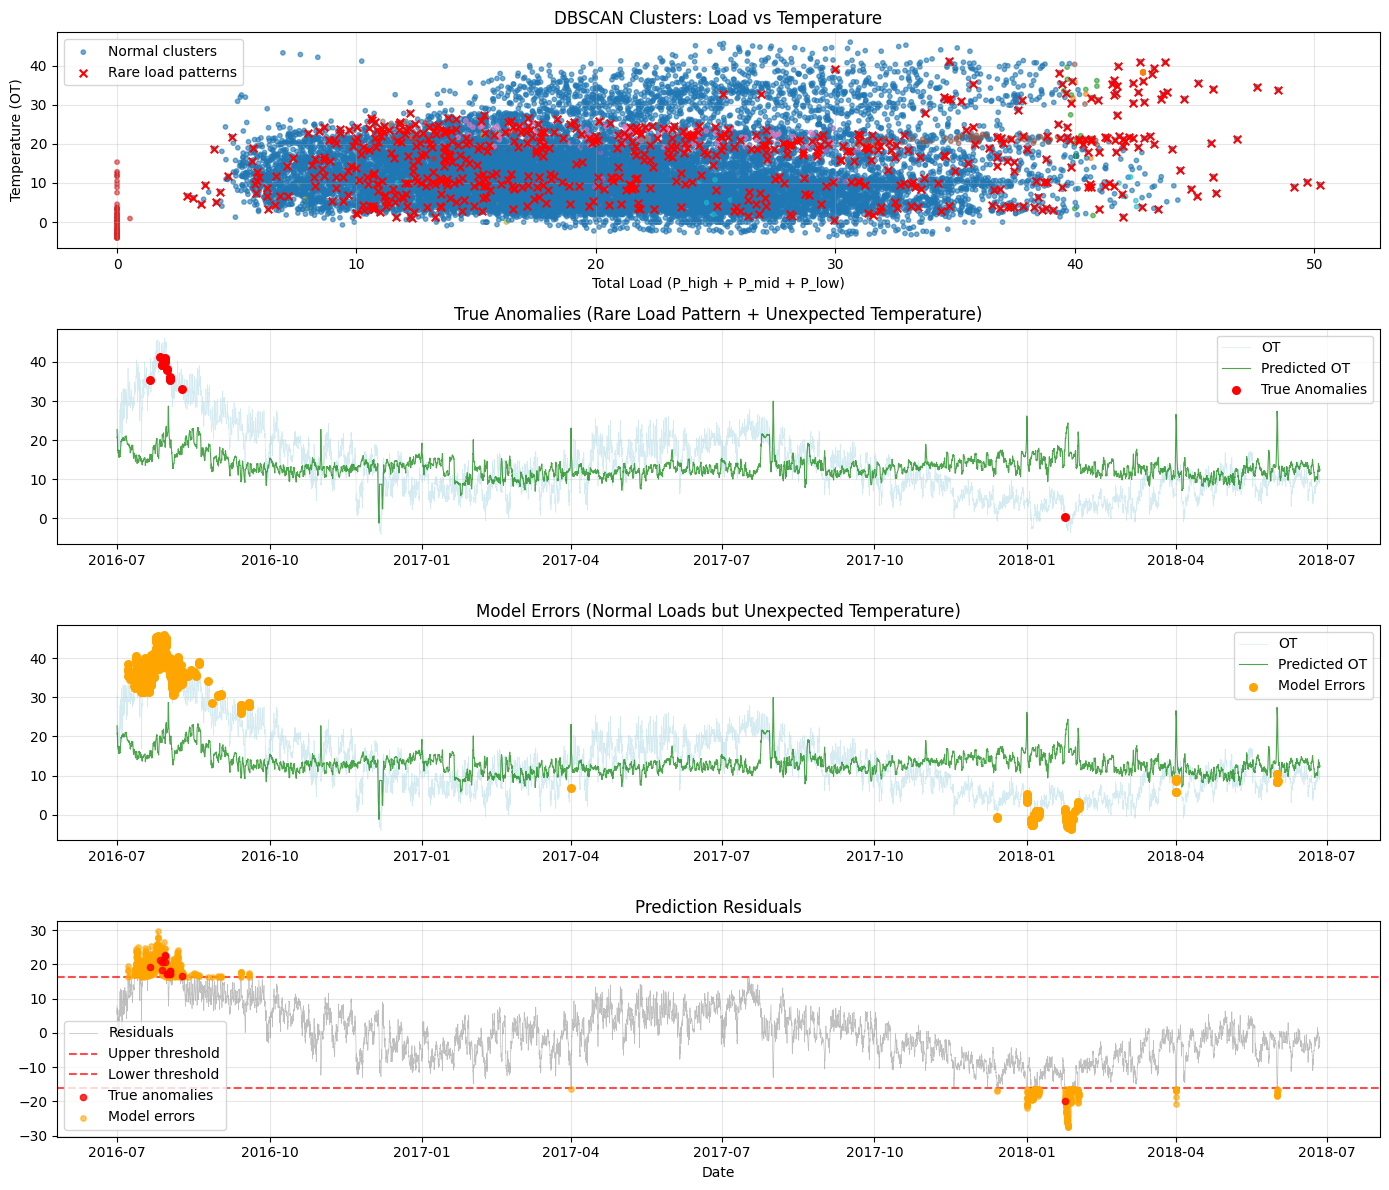

In [12]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

df_best['P_total'] = df_best['P_high'] + df_best['P_mid'] + df_best['P_low']

# Plot 1: Load vs Temperature with DBSCAN clusters
scatter = axes[0].scatter(df_best['P_total'], df_best['OT'], 
                         c=df_best['cluster'], cmap='tab10', 
                         s=10, alpha=0.6, label='Normal clusters')
axes[0].scatter(df_best.loc[dbscan_anomaly, 'P_total'],
               df_best.loc[dbscan_anomaly, 'OT'],
               color='red', s=30, marker='x', label='Rare load patterns', zorder=5)
axes[0].set_xlabel('Total Load (P_high + P_mid + P_low)')
axes[0].set_ylabel('Temperature (OT)')
axes[0].set_title('DBSCAN Clusters: Load vs Temperature')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: True anomalies (rare loads + unexpected temp)
axes[1].plot(df_best['date'], df_best['OT'], alpha=0.5, label='OT', linewidth=0.5, color='lightblue')
axes[1].plot(df_best['date'], df_best['OT_pred'], alpha=0.7, label='Predicted OT', linewidth=0.8, color='green')
axes[1].scatter(df_best.loc[final_anomaly, 'date'],
               df_best.loc[final_anomaly, 'OT'],
               color='red', s=30, label='True Anomalies', zorder=5)
axes[1].set_title('True Anomalies (Rare Load Pattern + Unexpected Temperature)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Model errors (normal loads but unexpected temp)
axes[2].plot(df_best['date'], df_best['OT'], alpha=0.5, label='OT', linewidth=0.5, color='lightblue')
axes[2].plot(df_best['date'], df_best['OT_pred'], alpha=0.7, label='Predicted OT', linewidth=0.8, color='green')
axes[2].scatter(df_best.loc[model_error, 'date'],
               df_best.loc[model_error, 'OT'],
               color='orange', s=30, label='Model Errors', zorder=5)
axes[2].set_title('Model Errors (Normal Loads but Unexpected Temperature)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Plot 4: Residuals with distinction
axes[3].plot(df_best['date'], df_best['residual'], alpha=0.5, label='Residuals', linewidth=0.5, color='gray')
axes[3].axhline(residual_threshold, ls='--', color='red', alpha=0.7, label='Upper threshold')
axes[3].axhline(-residual_threshold, ls='--', color='red', alpha=0.7, label='Lower threshold')
axes[3].scatter(df_best.loc[final_anomaly, 'date'],
               df_best.loc[final_anomaly, 'residual'],
               color='red', s=20, alpha=0.8, label='True anomalies', zorder=5)
axes[3].scatter(df_best.loc[model_error, 'date'],
               df_best.loc[model_error, 'residual'],
               color='orange', s=15, alpha=0.6, label='Model errors', zorder=4)
axes[3].set_title('Prediction Residuals')
axes[3].set_xlabel('Date')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# True anomalies: rare loads + unexpected temperature
true_anomalies = df_best.loc[final_anomaly, [
    'date', 'OT', 'OT_pred', 'residual', 'cluster',
    'P_high', 'P_mid', 'P_low', 'P_total'
]].copy()

true_anomalies['abs_residual'] = true_anomalies['residual'].abs()
true_anomalies['severity_score'] = (
    (true_anomalies['abs_residual'] / residual_threshold) * 0.7 +
    (true_anomalies['OT'] / df_best['OT'].max()) * 0.3
)

true_anomalies = true_anomalies.sort_values('severity_score', ascending=False)
true_anomalies.to_csv("true_anomalies.csv", index=False)

# Model errors: normal loads but high residuals
if model_errors > 0:
    model_errors_df = df_best.loc[model_error, [
        'date', 'OT', 'OT_pred', 'residual', 'cluster',
        'P_high', 'P_mid', 'P_low', 'P_total'
    ]].copy()
    model_errors_df['abs_residual'] = model_errors_df['residual'].abs()
    model_errors_df.to_csv("model_errors.csv", index=False)

print(f"Exported {len(true_anomalies)} true anomalies to true_anomalies.csv")
if model_errors > 0:
    print(f"Exported {model_errors} model errors to model_errors.csv")

print(f"\nTop 5 most severe TRUE anomalies:")
print(true_anomalies.head()[['date', 'OT', 'OT_pred', 'abs_residual', 'severity_score']])

Exported 15 true anomalies to true_anomalies.csv
Exported 841 model errors to model_errors.csv

Top 5 most severe TRUE anomalies:
                   date         OT    OT_pred  abs_residual  severity_score
697 2016-07-30 01:00:00  41.012001  18.163236     22.848765        1.251950
696 2016-07-30 00:00:00  40.872002  18.435665     22.436337        1.233267
621 2016-07-26 21:00:00  41.223000  19.884992     21.338007        1.188230
648 2016-07-28 00:00:00  39.324001  18.558329     20.765672        1.151186
694 2016-07-29 22:00:00  39.887001  19.277091     20.609910        1.148145


    INTERPRETATION
True Anomalies: Rare load patterns + Unexpected temperature response
Could likely be causeed by equipment degradation, sensor issues, unusual operating conditions

Model Errors: Normal loads + Unexpected temperature
Could likely be caused by model drift, seasonal effects, need for retraining